# KAN: Kolmogorov–Arnold Networks

この章では、Kolmogorov-Arnold Networks (KAN)について簡単に紹介する。

KANは、2024年4月に提案された新しいモデルで、ニューラルネットワーク(多層パーセプトロン, MLP)を置き換える(かもしれない)手法だとして注目を集めた。

Ziming Liu, Yixuan Wang, Sachin Vaidya, Fabian Ruehle, James Halverson, Marin Soljačić, Thomas Y. Hou, Max Tegmark, [arXiv:2404.19756](https://arxiv.org/abs/2404.19756)

筆頭著者によるGithubレポジトリ[pykan](https://github.com/KindXiaoming/pykan)を参照しながら解説とチュートリアルを行う。


## 概要

KANの根幹は、「有界な領域上の連続な多変量関数は、有界領域上の単変数関数の合成で表現できる」というKolmogorov-Arnoldの表現定理である。

入力に対して予め決められた非線形関数(Affine変換→活性化関数)と学習可能な重みを持つ関数を構成するMLPと対照的に、
KANは、ノード間を繋ぐ関数を学習することで、任意の多変量関数を表現するという特徴がある。

簡単のため、$d$次元の入力$\mathbf{x}$を考えた単層のMLPとKANを比較する。

$$
\begin{align}
\text{MLP:} \quad f(\mathbf{x}) &= \sum^n_{i=1} a_i \sigma(\mathbf{w}_i \cdot \mathbf{x} + b_i)  \\
\text{KAN:} \quad f(\mathbf{x}) &= f(x_1, \cdots, x_d) = 
\sum^{2d+1}_{q=1} \Phi_q \left( \sum^d_{p=1} \phi_{q,p} (x_p) \right)
\end{align}
$$
ここで、$\phi_{p,q}: [0,1] \to \mathbb{R}$、$\Phi_q: \mathbb{R} \to \mathbb{R}$である。
後者は単層といいつつ、単変数関数の合成になっていることに注意。

一般には、2-layerで幅$2d+1$のKolmogorov-Arnold表現は連続ではないが、KANでは文字通り、これを多層に拡張する。

## KAN: Kolmogorov-Arnold Networksの定式化

KANは、次のように定式化される。

$$f(x)={\bf \Phi}_{\rm out}\circ{\bf \Phi}_{\rm in}\circ {\bf x}$$

ここで、

$${\bf \Phi}_{\rm in}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n}(\cdot) \\ \vdots & & \vdots \\ \phi_{2n+1,1}(\cdot) & \cdots & \phi_{2n+1,n}(\cdot) \end{pmatrix},\quad {\bf \Phi}_{\rm out}=\begin{pmatrix} \Phi_1(\cdot) & \cdots & \Phi_{2n+1}(\cdot)\end{pmatrix}$$

である。以下のように、写像を一般化してKolmogorov-Arnold layerと呼ぶ。

$${\bf \Phi}= \begin{pmatrix} \phi_{1,1}(\cdot) & \cdots & \phi_{1,n_{\rm in}}(\cdot) \\ \vdots & & \vdots \\ \phi_{n_{\rm out},1}(\cdot) & \cdots & \phi_{n_{\rm out},n_{\rm in}}(\cdot) \end{pmatrix}$$

そうすると、${\bf \Phi_{\rm in}}, {\bf \Phi_{\rm out}}$はそれぞれ$(n_{\rm in}, n_{\rm in})=(n,2n+1)$, $(n_{\rm out}, n_{\rm out})=(2n+1,1)$の場合とみなせる。

これを多層に拡張すると

$${\rm KAN}({\bf x})={\bf \Phi}_{L-1}\circ\cdots \circ{\bf \Phi}_1\circ{\bf \Phi}_0\circ {\bf x}$$

となる。なお、$l$番目のレイヤーが$(n_{l+1}, n_{l})$の形を持つとする。

論文では特にこの$\phi$を、B-spline関数を用いて表現することを提案している。

## Implementation details

KANレイヤーの構造は非常にシンプルだが、著者らは3つの"key tricks"を提案している。

1. Residual activation functions:
   単純なsplineの合成では関数の近似が不十分な場合があるため、バックグラウンドとも呼ぶべき基底関数とsplineを重ね合わせている

    $$
    \phi(x) = w_b b(x) + w_s \mathrm{spline}(x)\\
    \mathrm{spline}(x) = \sum_i c_i B_i(x)\\
    b(x) = \mathrm{silu}(x) = x / (1 + \exp(-x))
    $$

    係数$c_i$は学習可能であり、$B_i(x)$はB-spline関数である。
    $w_b$と$w_s$の項は冗長になりうるものの、これにより関数の表現力が向上する。

2. Initialization scales:

    それぞれの活性化関数は$w_s=1$になるようつまり$\mathrm{spline}(x) \approx 0$になるよう初期化する。
    $w_b$はXavierの初期化を用いる。

3. Update of spline grids:

    splineは有界な領域で定義されているため、モデルの表現力を向上させるために、学習中にsplineのグリッドをon the flyで更新する。

## pykanを用いたチュートリアル

```python
# python==3.9.7
matplotlib==3.6.2
numpy==1.24.4
scikit_learn==1.1.3
setuptools==65.5.0
sympy==1.11.1
torch==2.2.2
tqdm==4.66.2
```

In [6]:
#!pip install pykan

**KANモデルの初期化**

2次元入力、1次元出力, 隠れそうのノード数は5として、cubic B-spline (k=3)をグリッド数5で初期化する。

In [7]:
from kan import *
torch.set_default_dtype(torch.float64)
model = KAN(width=[2,5,1], grid=5, k=3, seed=42)

checkpoint directory created: ./model
saving model version 0.0


**データセットの作成**

$$
f(x,y) = \exp(\sin(\pi x) + y^2)
$$

に従うデータセットを作成する。(x,y)は[0,1]の範囲でランダムに生成する。

In [8]:
from kan.utils import create_dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

**初期段階のKANの可視化**

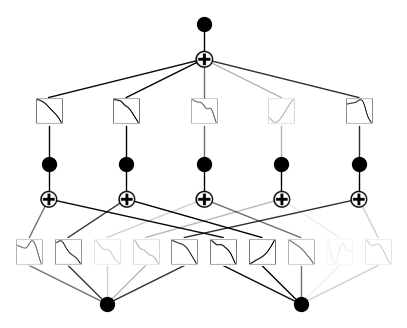

In [9]:
# plot KAN at initialization
model(dataset['train_input'])
model.plot()

**スパース正則化を用いてKANを学習する**

In [10]:
model.fit(dataset, opt="LBFGS", steps=50, lamb=0.001);

| train_loss: 6.19e-03 | test_loss: 6.58e-03 | reg: 7.86e+00 | : 100%|█| 50/50 [00:09<00:00,  5.14it

saving model version 0.1


**訓練後のKANの可視化**

不要なところを取り除く`prune`メソッドを使う。

saving model version 0.2


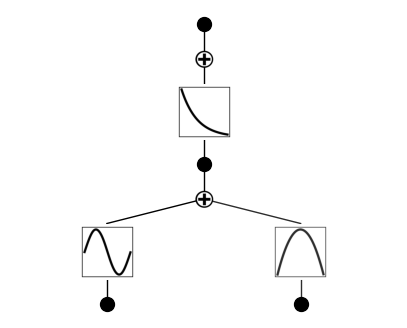

In [11]:
model = model.prune()
model.plot()

**さらに訓練を進めて再度プロット**

In [12]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 4.65e-03 | test_loss: 4.68e-03 | reg: 7.72e+00 | : 100%|█| 50/50 [00:02<00:00, 23.15it

saving model version 0.3


gridをrefineする

In [13]:
model = model.refine(10)

saving model version 0.4


In [14]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 2.92e-04 | test_loss: 3.07e-04 | reg: 7.72e+00 | : 100%|█| 50/50 [00:02<00:00, 19.60it

saving model version 0.5


**シンボリック回帰を行う(自動 or 手動)**

In [15]:
mode = "auto" # "manual"
if mode == "manual":
    # manual mode
    model.fix_symbolic(0,0,0,'sin');
    model.fix_symbolic(0,1,0,'x^2');
    model.fix_symbolic(1,0,0,'exp');
elif mode == "auto":
    # automatic mode
    lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
    model.auto_symbolic(lib=lib)

fixing (0,0,0) with sin, r2=0.9999999698716154, c=2
fixing (0,1,0) with x^2, r2=0.9999999973252476, c=2
fixing (1,0,0) with exp, r2=0.9999999992839835, c=2
saving model version 0.6


In [16]:
model.fit(dataset, opt="LBFGS", steps=50);

| train_loss: 1.79e-09 | test_loss: 1.71e-09 | reg: 0.00e+00 | : 100%|█| 50/50 [00:00<00:00, 65.51it

saving model version 0.7


**シンボリック回帰の結果を表示**

In [17]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0],4)

1.0*exp(1.0*x_2**2 + 1.0*sin(3.1416*x_1))

元の$f(x,y) = \exp(\sin(\pi x) + y^2)$をバッチリ再現している。